(chap-W)=
# Waveform processing

```{contents} Sections
:local:
:depth: 2
```

```{div} full-width

In this lecture, we will learn how to download the seismic waveforms as recorded by seismometer and process them to retrive the ground motion. In this perspective, let us import the main python libraries

```

In [1]:
%matplotlib widget
import lab
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
from myst_nb import glue
np.set_printoptions(precision=3,suppress=True)
import warnings
warnings.filterwarnings("ignore")

```{div} full-width

and set the `Client` with INGV as provider

```

In [3]:
from obspy.clients.fdsn import Client

client = Client("INGV")
print(client)

FDSN Webservice Client (base url: http://webservices.ingv.it)
Available Services: 'dataselect' (v1.1.0), 'event' (v1.52.9), 'station' (v1.1.55), 'available_event_catalogs', 'available_event_contributors', 'eida-auth'

Use e.g. client.help('dataselect') for the
parameter description of the individual services
or client.help() for parameter description of
all webservices.


```{div} full-width

Then, we read the seismic inventory and the catalog containing only the 2016-08-24 M6 Accumuli earthquake that we downloaded in the  {numref}`Lecture %s <chap-L1>` {ref}`chap-L1` 

```

In [4]:
from obspy.core.event import read_events
from obspy.core.inventory import read_inventory

directory = "Amatrice-Norcia-Visso/"

file = directory+"Seismic_Inventory.xml"
inventory = read_inventory(file)

file = directory + "7073641_Accumuli.xml"
catalog = read_events(file)

```{div} full-width
and we get the `event` of 2016-08-24 M6 Accumuli earthquake and the preferred `origin` by the Bollettino Sismico Italiano 
```

In [5]:
event = catalog[0]
origin = event.preferred_origin()

```{tip}
:class: full-width

Here you can download the files {download}`Seismic_Inventory.xml<./Amatrice-Norcia-Visso/Seismic_Inventory.xml>` and  {download}`7073641_Accumuli.xml <./Amatrice-Norcia-Visso/7073641_Accumuli.xml>` and copy in the working directory `Amatrice-Norcia-Visso`  if you do not have get these files from the previous lecture. Otherwise, you can download the whole directory {download}`Amatrice-Norcia-Visso<https://unimibox.unimi.it/index.php/s/tet7yxSaaxTkZsP>`.
```

```{div} full-width
Hereinafter, we make a plot of the seismic stations of the `inventory` centred at the longitude and latitude of the prefferred `origin`
```

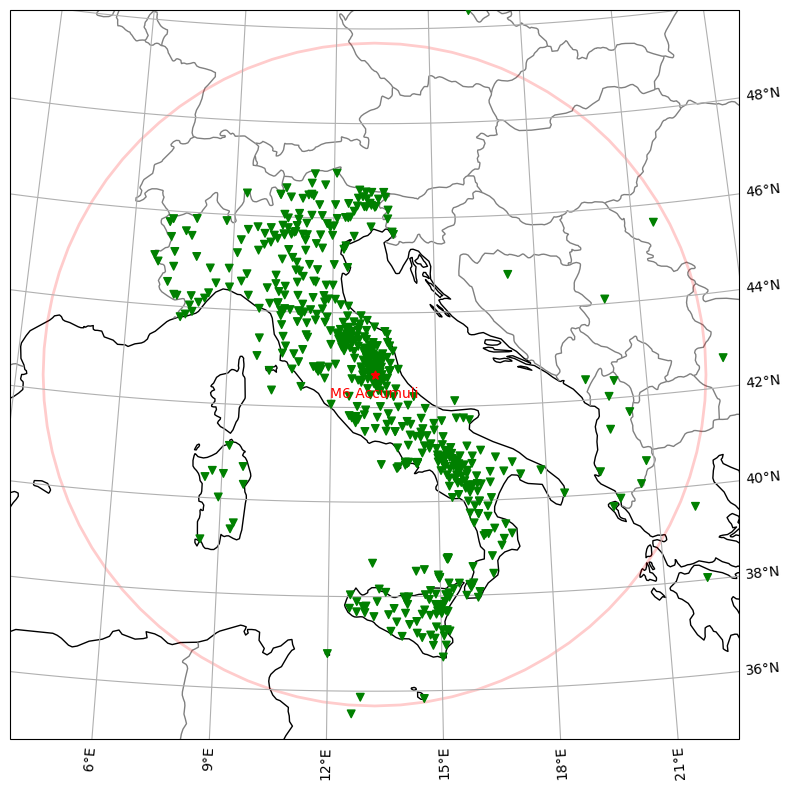

In [6]:
circle = dict(maxradius=7,longitude=origin.longitude,latitude=origin.latitude)
fig = lab.setup_map(circle, color="red", label="M6 Accumuli")
fig = inventory.plot(fig=fig, label=False, size=30, color="green")

## Downloading our first waveforms

```{div} full-width
Let us define the network and station codes of the case study seismic station  {glue:}`station`
```

In [7]:
network_code, station_code = "IV", "MRLC"

```{div} full-width

and select it from the inventory 

```

In [8]:
inv = inventory.select(network=network_code,station=station_code,time=origin.time)
station = inv[0][0]

print(station)

Station MRLC (Muro Lucano)
	Station Code: MRLC
	Channel Count: 18/24 (Selected/Total)
	2003-03-01T00:00:00.000000Z - 
	Access: open 
	Latitude: 40.7564, Longitude: 15.4889, Elevation: 605.0 m
	Available Channels:
	    ..HN[ZNE]   100.0 Hz  2011-08-08 to 2017-04-10
	    ..HH[ZNE]   100.0 Hz  2005-03-23 to None



```{div} full-width
Using the function `distance` from the module `geopy` we can calculate the distance between the seismic station {glue:}`station` and the earthquake origin
```

In [9]:
from geopy import distance as geopy_distance

distance = geopy_distance.distance((station.latitude,station.longitude),(origin.latitude,origin.longitude)).km
distance_deg = distance/6371*180/np.pi

print("Distance: {0:6.1f} [km] or {0:6.3f} [deg]".format(distance,distance_deg))

Distance:  285.9 [km] or 285.870 [deg]


In [10]:
glue("distance",np.round(distance*10)/10)

285.9

```{div} full-width
Here we make a geographic plot centered at the seismic station {glue:}`station` where we also show the earthquake origin (the red circle has the calculated distance of {glue:}`distance` km as radius)
```

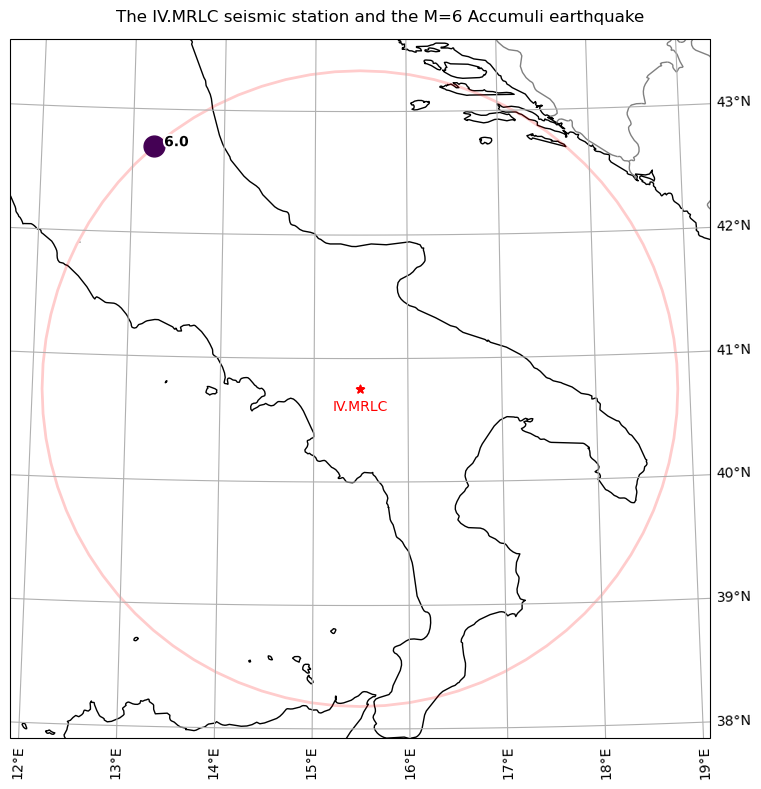

In [11]:
circle = dict(maxradius=distance_deg,longitude=station.longitude,latitude=station.latitude)
prefix = network_code+"."+station_code
title = "The "+prefix+" seismic station and the M=6 Accumuli earthquake"

fig = lab.setup_map(circle,color="red",label=prefix)
fig = catalog.plot(fig=fig,title=title)

```{div} full-width
Let us now download the waveforms for the selected seismic station that we will save in a file with the standard format [mini-seed](https://ds.iris.edu/ds/nodes/dmc/data/formats/miniseed/)
```

In [12]:
file = directory+prefix+"_Long.mseed"
print(file)

Amatrice-Norcia-Visso/IV.MRLC_Long.mseed


```{div} full-width
We first define the starttime and the endtime that we set 30 minutes before and 90 minutes after the origin time
```

In [13]:
from obspy import UTCDateTime

starttime = origin.time - 30 * 60    
endtime   = origin.time + 90 * 60  

```{div} full-width

and we get a list with all the channels of the seismic station
```

In [14]:
channels =  [ channel.code for channel in station]
channels = ",".join(channels)
print(channels)

HHE,HHN,HHZ,HNE,HNN,HNZ


```{div} full-width
We can now use the function `client.get_waveforms` to download the raw data giving as argument the network, station, location and channel codes, the time windows on which we are interested in and the file in which we want to save the data
```


In [15]:
client.get_waveforms(network_code,station_code,"*",channels, starttime=starttime, endtime=endtime, filename=file)

```{div} full-width
Using the function `read` from `obspy` we can read the file and get the `Stream` object that we have just downloaded
```

In [16]:
from obspy import read
stream = read(file)

print(stream)

16 Trace(s) in Stream:
IV.MRLC..HHE | 2016-08-24T01:06:30.430000Z - 2016-08-24T01:19:21.790000Z | 100.0 Hz, 77137 samples
IV.MRLC..HHE | 2016-08-24T01:19:23.120000Z - 2016-08-24T02:37:33.250000Z | 100.0 Hz, 469014 samples
IV.MRLC..HHE | 2016-08-24T02:37:34.440000Z - 2016-08-24T02:52:34.490000Z | 100.0 Hz, 90006 samples
IV.MRLC..HHE | 2016-08-24T02:52:36.660000Z - 2016-08-24T03:06:32.580000Z | 100.0 Hz, 83593 samples
IV.MRLC..HHN | 2016-08-24T01:06:28.700000Z - 2016-08-24T01:13:24.980000Z | 100.0 Hz, 41629 samples
IV.MRLC..HHN | 2016-08-24T01:13:26.170000Z - 2016-08-24T01:19:21.740000Z | 100.0 Hz, 35558 samples
IV.MRLC..HHN | 2016-08-24T01:19:23.430000Z - 2016-08-24T03:06:32.640000Z | 100.0 Hz, 642922 samples
IV.MRLC..HHZ | 2016-08-24T01:06:28.410000Z - 2016-08-24T01:19:20.910000Z | 100.0 Hz, 77251 samples
IV.MRLC..HHZ | 2016-08-24T01:19:23.080000Z - 2016-08-24T03:06:33.050000Z | 100.0 Hz, 642998 samples
IV.MRLC..HNE | 2016-08-24T01:06:31.430000Z - 2016-08-24T03:06:33.230000Z | 100.0 Hz

```{div} full-width
It can be seen as a list of `Trace` objects
```

In [17]:
for trace in stream:
    print(trace)

IV.MRLC..HHE | 2016-08-24T01:06:30.430000Z - 2016-08-24T01:19:21.790000Z | 100.0 Hz, 77137 samples
IV.MRLC..HHE | 2016-08-24T01:19:23.120000Z - 2016-08-24T02:37:33.250000Z | 100.0 Hz, 469014 samples
IV.MRLC..HHE | 2016-08-24T02:37:34.440000Z - 2016-08-24T02:52:34.490000Z | 100.0 Hz, 90006 samples
IV.MRLC..HHE | 2016-08-24T02:52:36.660000Z - 2016-08-24T03:06:32.580000Z | 100.0 Hz, 83593 samples
IV.MRLC..HHN | 2016-08-24T01:06:28.700000Z - 2016-08-24T01:13:24.980000Z | 100.0 Hz, 41629 samples
IV.MRLC..HHN | 2016-08-24T01:13:26.170000Z - 2016-08-24T01:19:21.740000Z | 100.0 Hz, 35558 samples
IV.MRLC..HHN | 2016-08-24T01:19:23.430000Z - 2016-08-24T03:06:32.640000Z | 100.0 Hz, 642922 samples
IV.MRLC..HHZ | 2016-08-24T01:06:28.410000Z - 2016-08-24T01:19:20.910000Z | 100.0 Hz, 77251 samples
IV.MRLC..HHZ | 2016-08-24T01:19:23.080000Z - 2016-08-24T03:06:33.050000Z | 100.0 Hz, 642998 samples
IV.MRLC..HNE | 2016-08-24T01:06:31.430000Z - 2016-08-24T03:06:33.230000Z | 100.0 Hz, 720181 samples
IV.MRL

In [18]:
glue("numtraces", len(stream))

16

### Gaps

```{div} full-width
Because we downloaded the raw data for both the velocimeter (HH*) and the accelerometer (HN*), we should expect only six traces, i.e. three traces for each kind of sensor. The fact that we got {glue:}`numtraces` traces instead of 6 is due to the presence of gaps
```

In [19]:
stream.print_gaps()

Source            Last Sample                 Next Sample                 Delta           Samples 
IV.MRLC..HHE      2016-08-24T01:19:21.790000Z 2016-08-24T01:19:23.120000Z 1.320000        132     
IV.MRLC..HHE      2016-08-24T02:37:33.250000Z 2016-08-24T02:37:34.440000Z 1.180000        118     
IV.MRLC..HHE      2016-08-24T02:52:34.490000Z 2016-08-24T02:52:36.660000Z 2.160000        216     
IV.MRLC..HHN      2016-08-24T01:13:24.980000Z 2016-08-24T01:13:26.170000Z 1.180000        118     
IV.MRLC..HHN      2016-08-24T01:19:21.740000Z 2016-08-24T01:19:23.430000Z 1.680000        168     
IV.MRLC..HHZ      2016-08-24T01:19:20.910000Z 2016-08-24T01:19:23.080000Z 2.160000        216     
IV.MRLC..HNN      2016-08-24T01:28:10.640000Z 2016-08-24T01:28:12.890000Z 2.240000        224     
IV.MRLC..HNN      2016-08-24T02:44:06.600000Z 2016-08-24T02:44:08.850000Z 2.240000        224     
IV.MRLC..HNZ      2016-08-24T01:13:22.280000Z 2016-08-24T01:13:24.530000Z 2.240000        224     
IV.MRLC..H

```{div} full-width
Let us give a look to the first `trace`. It contains both data
```

In [20]:
trace = stream[0]
print("DATA:\n\n", trace.data)
print("\nNumber of samplings:\n\n", len(trace.data))

DATA:

 [-184  -45 -148 ... 1279 1154 1026]

Number of samplings:

 77137


```{div} full-width
and meta data
```

In [21]:
print("\nMETADATA:\n\n",trace.stats)


METADATA:

          network: IV
         station: MRLC
        location: 
         channel: HHE
       starttime: 2016-08-24T01:06:30.430000Z
         endtime: 2016-08-24T01:19:21.790000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 77137
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 244, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 5043712})


In [22]:
glue("sampling_rate", int(trace.stats.sampling_rate))
glue("starttime", trace.stats.starttime)
glue("endtime", trace.stats.endtime)
glue("delta", trace.stats.delta)

100

2016-08-24T01:06:30.430000Z

2016-08-24T01:19:21.790000Z

0.01

```{div} full-width
The data are integers numbers, the so called counts, which are the outputs of the digitizer of the seismometer. From the metadata, instead, we can learn that the data refer to the time period from {glue:}`starttime` to {glue:}`endtime` sampled every {glue:}`delta` s (i.e., with a sampling rate of {glue:}`sampling_rate` Hz).

We can have a first look to the data plotting them using the function `lab.plot_time` which also show the gaps with vertical red ranges
```

In [23]:
del fig
plt.ioff()

In [24]:
title="Raw data timeseries (counts) and the gaps (vertical red ranges)"

fig = lab.plot_time(stream, origin.time, title=title)

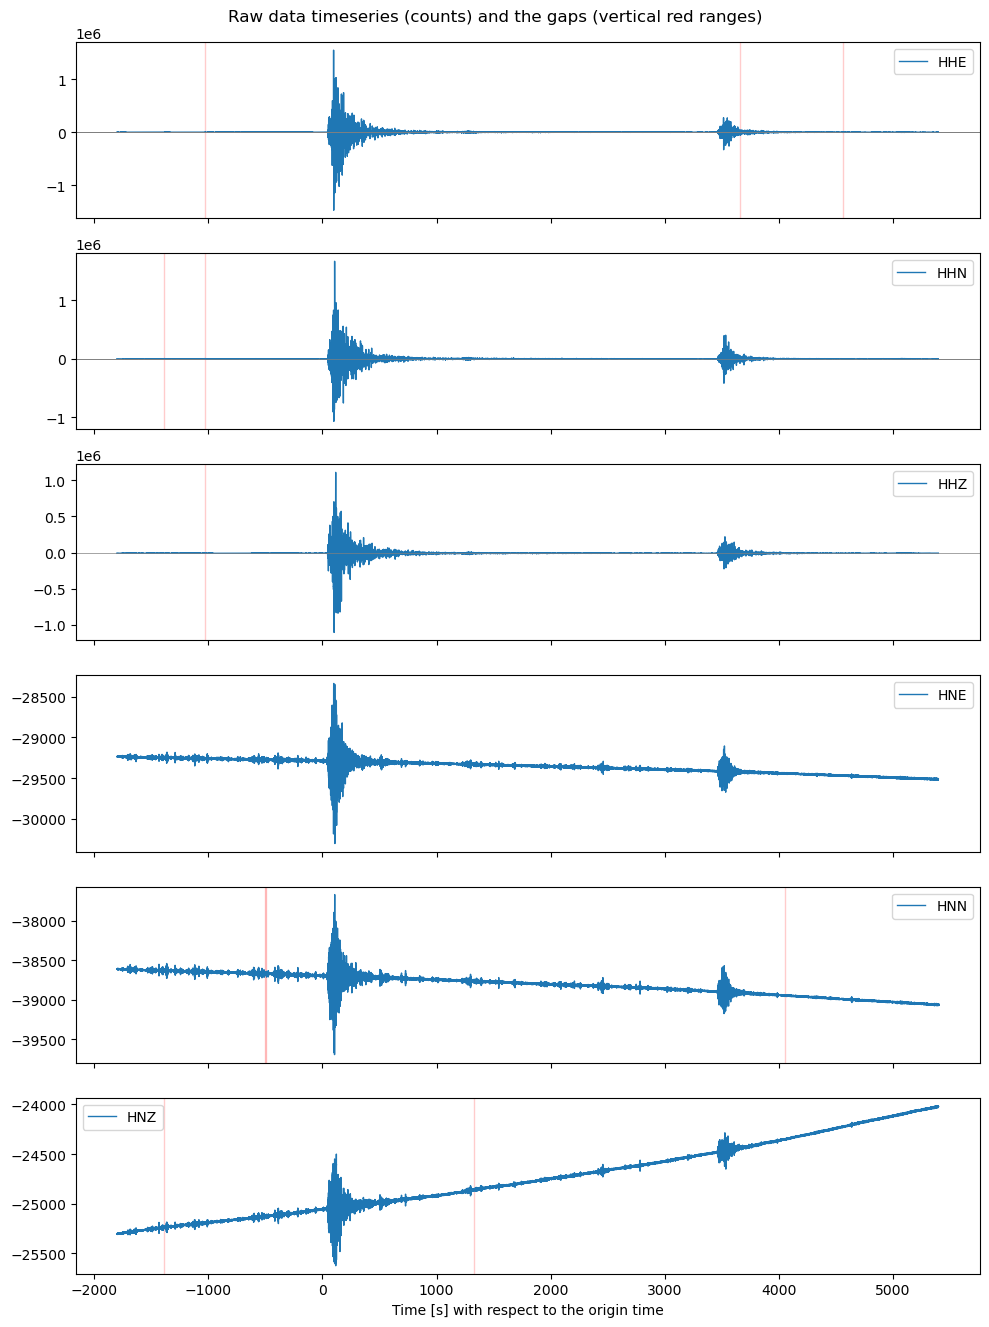

In [25]:
glue("fig_stream", fig)

````{div} full-width

```{glue:figure} fig_stream
:name: "fig-stream"

Raw data time series. The reference time $t=0$ corresponds to the origin time of the M6 Accumuli earthquake and the red vertical bands indicate gaps in the time series due to malfunctionings of the channels of the seismometers or problems during the data transfer.
```
````

In [26]:
plt.ion()
%matplotlib inline

### Aftershocks

```{div} full-width
Let us now download all the earthquakes with $M\geq3.5$ occurred in the same period for which we download the waveforms in a circle of radius slighly grater (by about 50 km) than the distance between the seismic station and the M6 Accumuli earthquake
```

In [27]:
circle = dict(maxradius=distance_deg+0.5, longitude=station.longitude, latitude=station.latitude)
file = directory+"Events_"+network_code+"."+station_code+".xml"
client.get_events(**circle, starttime=starttime, endtime=endtime, minmagnitude=3.5, filename=file)
catalog = read_events(file)

print(catalog)

19 Event(s) in Catalog:
2016-08-24T02:59:35.240000Z | +42.799,  +13.131 | 3.9  Mw | manual
2016-08-24T02:55:39.900000Z | +42.646,  +13.309 | 3.6  ML | manual
...
2016-08-24T01:37:26.580000Z | +42.712,  +13.253 | 4.5  ML | manual
2016-08-24T01:36:32.000000Z | +42.698,  +13.233 | 6.0  Mw | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'


```{div} full-width
and plot them
```

In [28]:
plt.ioff()

In [29]:
title = "The "+network_code+"."+station_code+" seismic station and the aftershocks"

fig = lab.setup_map(circle, color="red", label=station.code)
fig = catalog.plot(fig=fig, show=False, title=title)

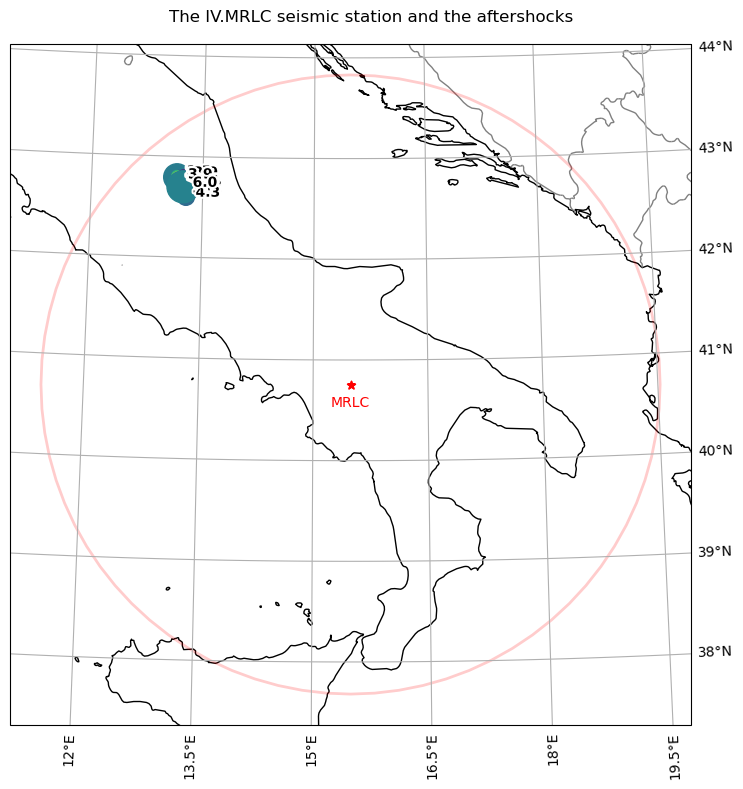

In [30]:
plt.ion()
%matplotlib inline
glue("fig_aftershocks", fig, display=False)

````{div} full-width
```{glue:figure} fig_aftershocks
:name: fig-aftershocks

Earthquakes (M>3.5) occurred from 30 minutes before and 90 minutes after the M=6 Accumuli earthquake in the surroudings of the seismic station {glue:}`station`. We note that there is only one cluster of earthquakes. Considering that they have occurred after the M=6 Accumuli earthquake, we can consider them after shocks of the main shock.
```
````

```{div} full-width
Let us now plot again the raw data time series and draw vertical green lines in correspondence of the origin time of each earthquake in the just downloaded `catalog` 
```

In [31]:
del fig
plt.ioff()

In [32]:
title="Raw data time series (counts) and the aftershocks (green vertical lines)"

fig = lab.plot_time(stream, origin.time, title=title) 

for new_event in catalog:
    new_origin = new_event.preferred_origin()
    for ax in fig.axes:
        time = new_origin.time-origin.time
        ax.axvline(time, linewidth=0.5, color="green")

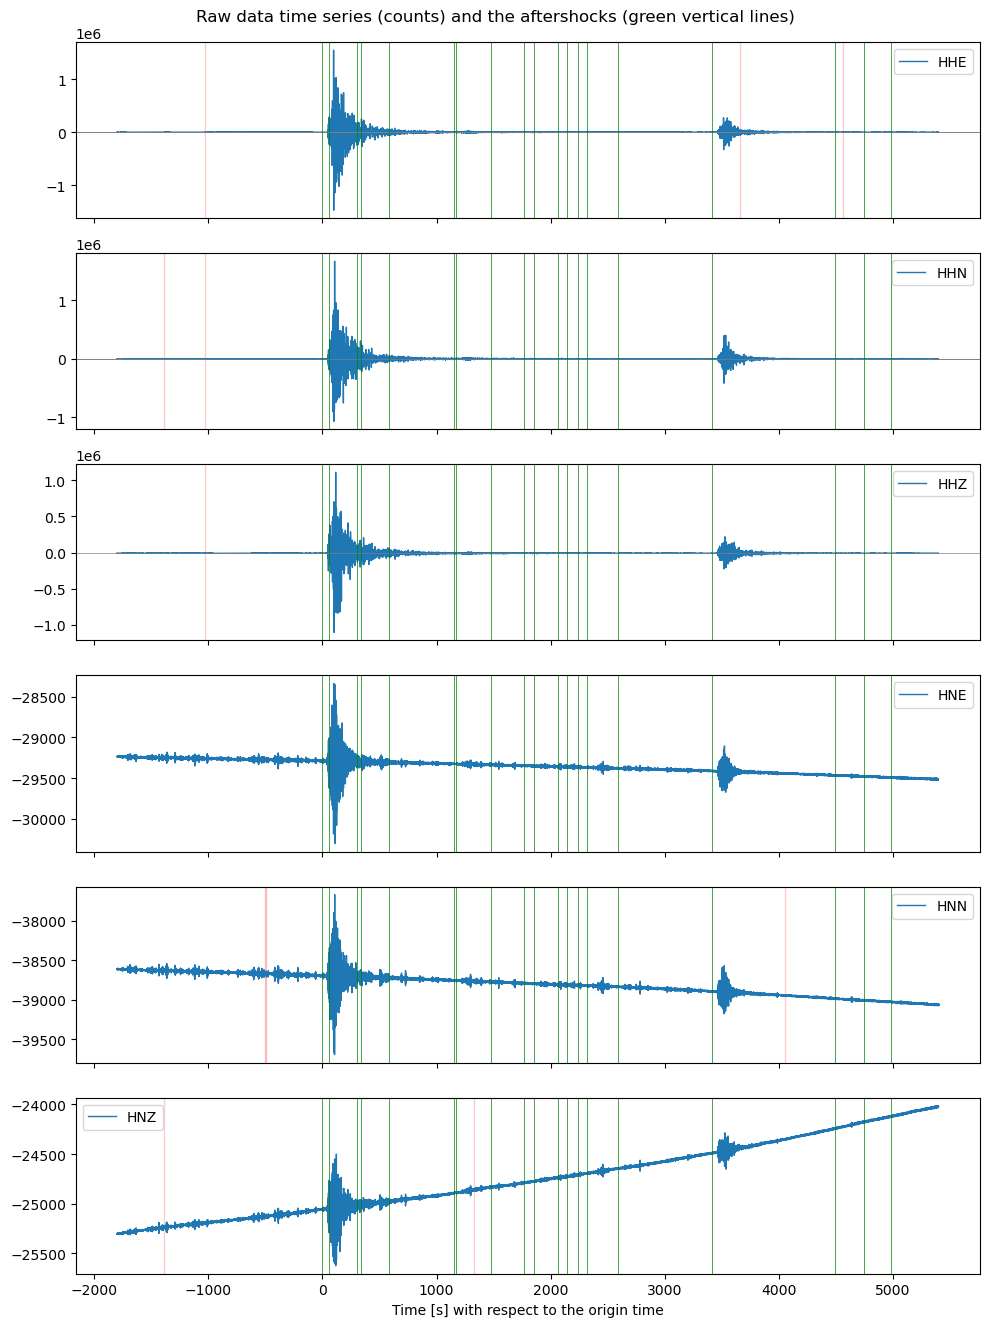

In [33]:
plt.ion()
%matplotlib inline
glue("fig_gaps_aftreshocks", fig, display=False)

````{div} full-width
```{glue:figure} fig_gaps_aftreshocks
:name: fig-gaps-aftreshocks

As {numref}`Figure {number} <fig-stream>` but with vertical green lines drawn in correspondence of the origin time of the aftershocks.
```
````

## Processing

```{div} full-width
For the sake of simplicity, let us select from the `stream` only the vertical channels and focus only on 500 seconds before and 1000 seconds after the origin time (for a total of 25 minutes) and plot the raw data of the two selected and trimmed traces 
```

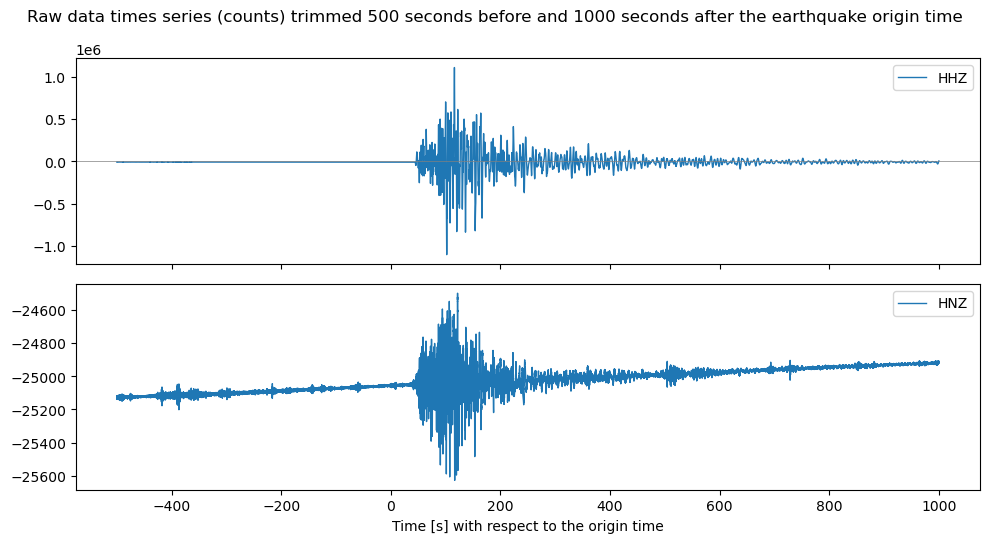

In [34]:
stream = stream.select(channel="*Z")
stream.trim(origin.time-500, endtime=origin.time+1000)

title = "Raw data times series (counts) trimmed 500 seconds before and 1000 seconds after the earthquake origin time"
fig = lab.plot_time(stream, origin.time, title=title)

```{div} full-width
For the sake of comparison between the original and processed streams, we remove the mean values from all the trace
```

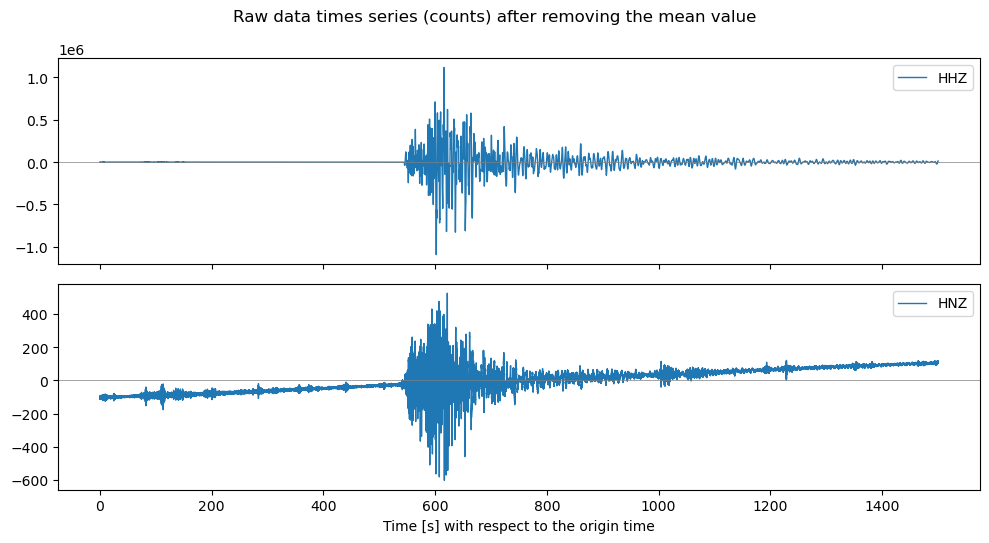

In [35]:
stream.detrend("constant")
title = "Raw data times series (counts) after removing the mean value"
fig = lab.plot_time(stream, title=title)

### Preprocessing

```{div} full-width

In order to retrieve the ground motion from the raw data, first we have to make them suitable for the Fast Fourier Transform (FFT). This means that we have to modify the traces so that they can be seen as periodic signals and that the operations of convolutions can be performed without wrap around effects.

In order to make periodic the data, first, we shall remove a long term trend for reducing the jump between the beginning and the end of the trace (using the method `stream.detrend` with `type="polynomial` we can fit a polynomial of given order to the data and remove it)

```

In [36]:
original_stream = stream.copy()
stream.detrend(type="polynomial", order=1);

```{div} full-width

Here, we have made a copy of the original `stream` before applying the `.detrend` method

Second, we shall apply a cosine taper for guaranting a smooth transition towards the same value (say zero) at the beginning and the end of the trace (using the method `stream.taper` with `type=cosine`). In this way the first and last samples of the trace will coincide and, so, there will be no issues concerning the artificial discontinuity when the the trace data will be seen as periodic. 
```

In [37]:
stream.taper(0.05, type="cosine");

```{div} full-width
Here, we plot the original and preprocessed stream drawing also the vertical ranges (in shaded blue) where the cosine taper acted
```

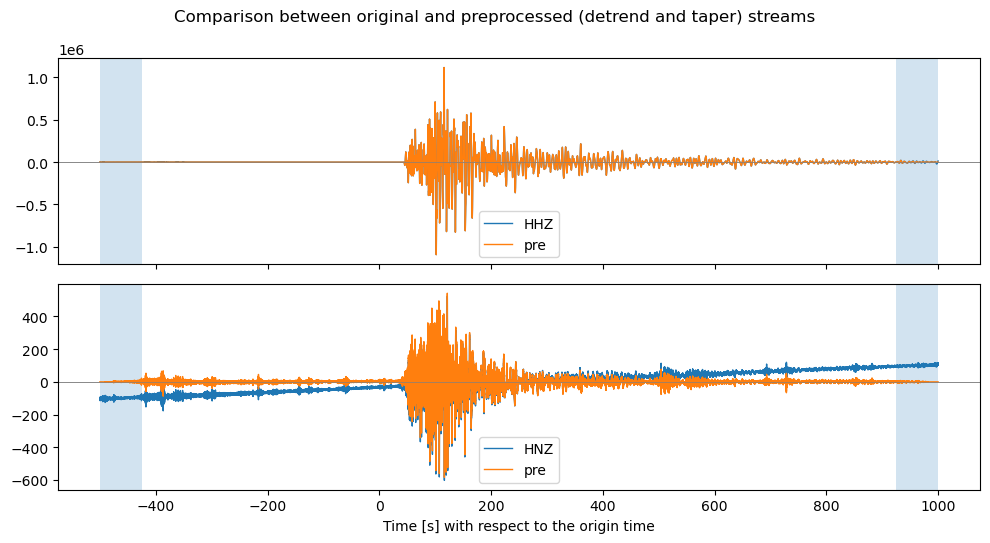

In [38]:
title = "Comparison between original and preprocessed (detrend and taper) streams"
fig = lab.plot_time(original_stream,  origin.time, title=title)
fig = lab.plot_time(stream,           origin.time, fig=fig, extra_label="pre")

for ax,trace in zip(fig.axes,original_stream):
    n, d = trace.stats.npts, trace.stats.delta
    T = (n*0.05)*d
    start = trace.stats.starttime-origin.time
    end   = trace.stats.endtime-origin.time
    ax.axvspan(start, start+T, alpha=0.2)
    ax.axvspan(end-T, end,     alpha=0.2)

```{div} full-width

In the end, in order to make safe the operation of convolution, we shall add to the trace some zero samples after its end, long enough to prohibit wrap around effects during convolution. This last task can be accomplieshed by doubling the length of the trace and setting to zero all the added samples (using the method `trace.trim`). The exact final number of the sampling is custoraily decided in order to speed up the FFT calculations and can be obtained using the function `_npts2nfft` from the module `obspy.signal.util` 

```

In [39]:
from obspy.signal.util import _npts2nfft

for trace in stream:
    n, d = trace.stats.npts, trace.stats.delta
    nn = _npts2nfft(n)
    T = (nn-n)*d
    endtime = trace.stats.endtime + T
    trace.trim(endtime=endtime,pad=True,fill_value=0)

```{div} full-width
Here, we plot the original and preprocessed streams drawing also the vertical range (in shaded blue) where the stream has been padded with zeros
```

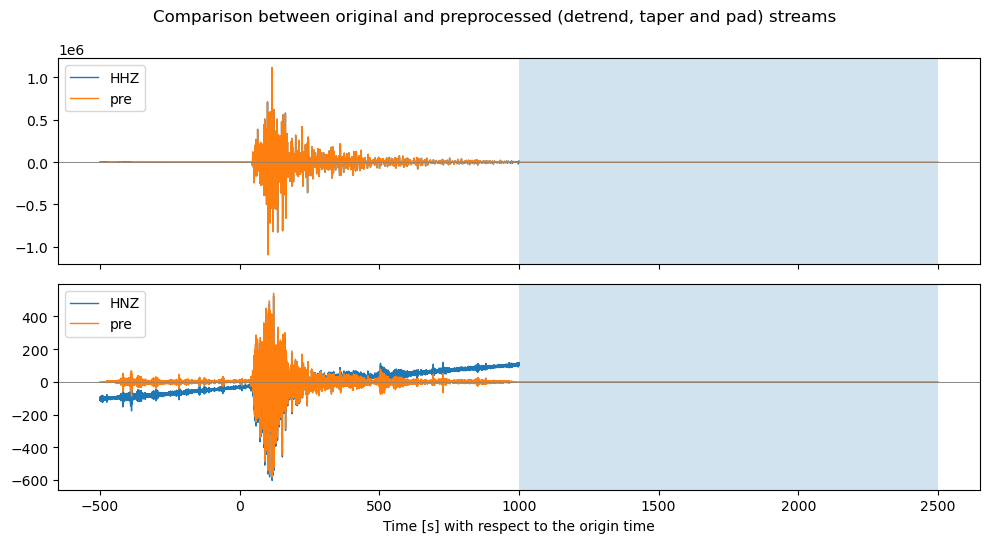

In [40]:
title = "Comparison between original and preprocessed (detrend, taper and pad) streams"
fig = lab.plot_time(original_stream, origin.time, title=title)
fig = lab.plot_time(stream,          origin.time, fig=fig, extra_label="pre")

for ax,original_trace,pre_trace in zip(fig.axes,original_stream,stream):
    start = original_trace.stats.endtime-origin.time
    end = trace.stats.endtime-origin.time
    ax.axvspan(start,end,alpha=0.2)

```{div} full-width
All these preprocessing steps are collected in the function `lab.preprocessing` and the same result is obtianed as follows
```

In [41]:
def preprocessing(stream,order=1,taper=0.05):
    pre_stream = stream.copy()
    pre_stream.detrend(type="polynomial",order=order)
    pre_stream.taper(taper,type="cosine")
    for trace in pre_stream:
        n, d = trace.stats.npts, trace.stats.delta
        nn = _npts2nfft(n)
        T = (nn-n)*d
        endtime = trace.stats.endtime + T
        trace.trim(endtime=endtime,pad=True,fill_value=0)
    return pre_stream

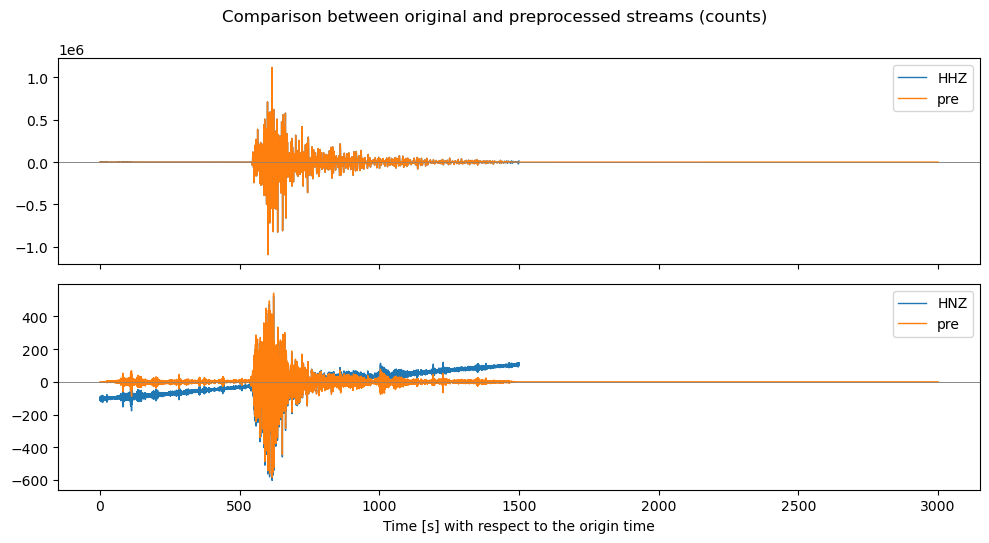

In [42]:
stream = lab.preprocessing(original_stream)

title = "Comparison between original and preprocessed streams (counts)"
fig = lab.plot_time(original_stream, title=title)
fig = lab.plot_time(stream,          fig=fig, extra_label="pre")

```{div} full-width
The importance of the preprocessing can be better appreciate by comparing the spectra of the original and processed streams
```

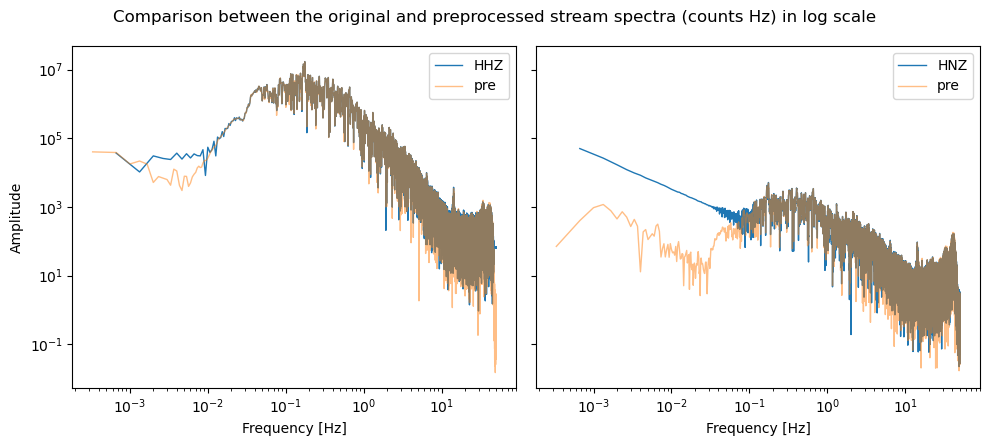

In [43]:
title = "Comparison between the original and preprocessed stream spectra (counts Hz) in log scale"
fig = lab.plot_fft(original_stream, sharey=True, title=title)
fig = lab.plot_fft(stream,          fig=fig, alpha=0.5, extra_label="pre")

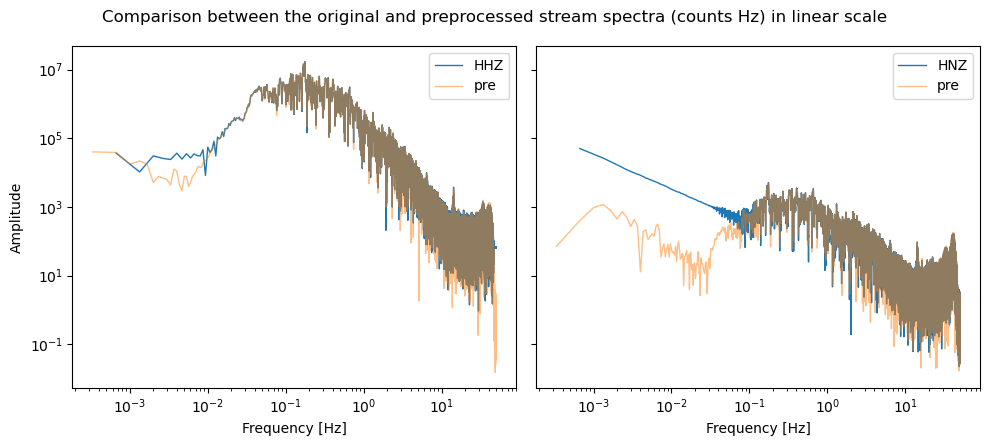

In [44]:
title = "Comparison between the original and preprocessed stream spectra (counts Hz) in linear scale"
fig = lab.plot_fft(original_stream, sharey=True, title=title, xscale="linear")
fig = lab.plot_fft(stream, extra_label="pre", fig=fig, alpha=0.5)

```{div} full-width

As we can see, especially for the accelerometer which is characterized by a strong linear trend, the spectrum of the preprocessed stream is smaller at low frequencies. Also, specially for the velocimeter, the spectrum of the preprocessed stream is smaller  at high frequency because we apply the cosine taper, thus removing the discontinuity between the end and the beginning of the timeseries.
```

### Response function

```{div} full-width
As already mentioned, what we have plotted so far are counts and so, in the following, we shall learn how to retrive the ground motion from them. In this perspective, we load the information about response function of the seismometers to each `trace` of the `stream` using the method `stream.attach_response` with argument an inventory where we can find the response functions
```

In [45]:
missing = stream.attach_response(inventory)
print("MISSING:",missing)

MISSING: []


```{div} full-width
This method return the list of traces for which the response function has not been found in the inventory. In the present case, the list is empty and, so, all the required response functions have been found.

Giving a look to the metadata of the first `trace` of the `stream` we now see that there is an additional field named `response`
```

In [46]:
trace = stream[0]
print(trace.stats)

         network: IV
         station: MRLC
        location: 
         channel: HHZ
       starttime: 2016-08-24T01:28:12.000000Z
         endtime: 2016-08-24T02:18:12.030000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 300004
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1783, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 5043712})
      processing: ['ObsPy 1.4.0: trim(endtime=UTCDateTime(2016, 8, 24, 1, 53, 12)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2016, 8, 24, 1, 28, 12))', "ObsPy 1.4.0: detrend(options={}::type='constant')", "ObsPy 1.4.0: detrend(options={'order': 1}::type='polynomial')", "ObsPy 1.4.0: taper(max_length=None::max_percentage=0.05::side='both'::type='cosine')", 'ObsPy 1.4.0: trim(endtime=UTCDateTime(2016, 8, 24, 2, 18, 12, 30000)::fill_value=0::nearest_sample=True::pad=True::starttime=None)']
        response: Chann

```{div} full-width
and, similar to what we have already done in {numref}`Lecture %s <chap-L1>` {ref}`chap-L1`, we plot it using the function `lab.plot_response`
```

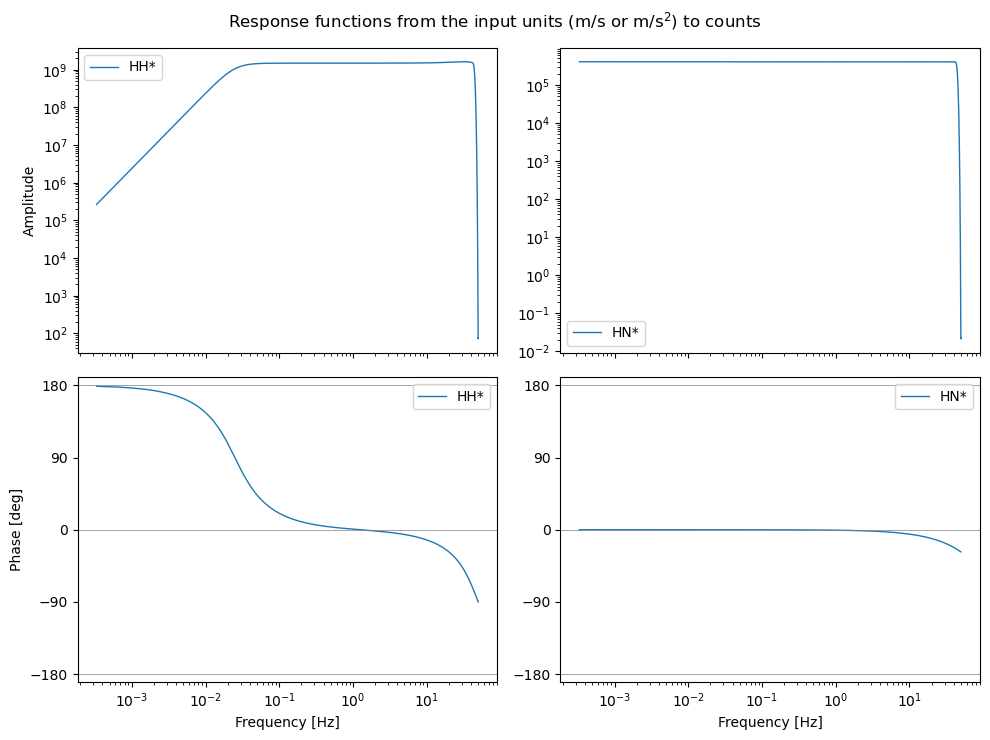

In [47]:
title="Response functions from the input units (m/s or m/s$^2$) to counts"
fig = lab.plot_response(stream, title=title)

```{div} full-width
Before removing the whole response functions, we can simply give a look to the processed stream removing the instrument sensitivities. In this way, we have a first estimate of the ground velocity (from the velocimeter) and of the ground acceleration (from the accelerometer), although it does not yet take into account the the frequency dependence of the the spectral amplitude of the response function and the phase delay
```

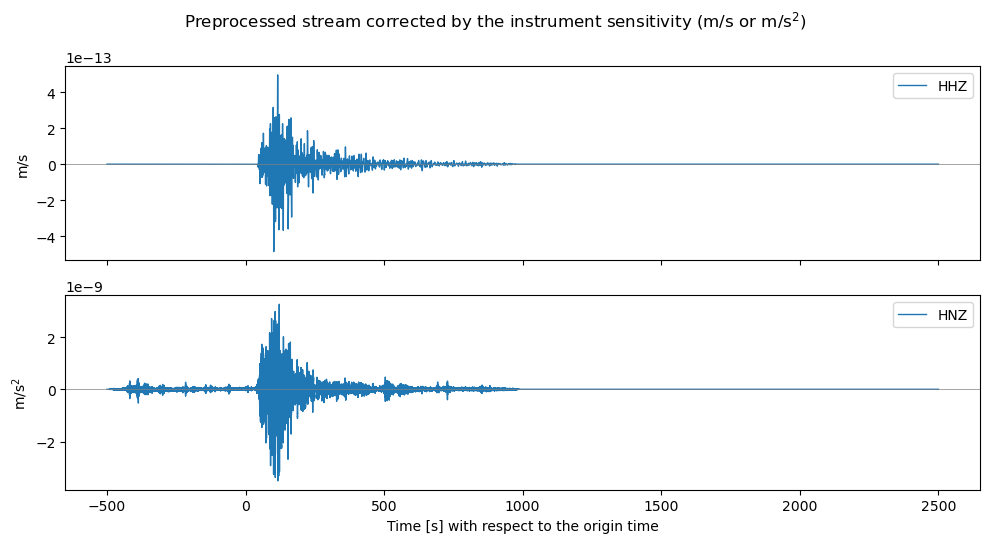

In [48]:
stream_sens = stream.copy()
stream_sens.remove_sensitivity()

title = "Preprocessed stream corrected by the instrument sensitivity (m/s or m/s$^2$)"
fig = lab.plot_time(stream_sens, origin.time, title=title, remove_sensitivity=True)
fig.axes[0].set_ylabel("m/s")
fig.axes[1].set_ylabel("m/s$^2$");

-------------
````{div} full-width

<font size="4"> **Exercise** </font>

Let us define two `Stream` objects with the traces for the only channels of velocimeter and of the accelerometer

````

In [49]:
acce = stream_sens.select(channel="HN*")
velo = stream_sens.select(channel="HH*")

```{div} full-width

**Tasks**

 1. Perform the first derivative with respect to time in the frequency domain of the `Stream` object `velo`
 1. Compare the `Stream` object `acce` and the first time derivative of `Stream` object `velo` in the time and spactral domain

```


```{div} full-width
**Solution 1**

Recalling eq. {eq}`T1:13`, we first define a function returning the frequencies `fs` and the discrete Fourier transform `Zs` of the trace data, as well as the number of samplings `n` and the time step `d`
```

In [50]:
###########################################################
def get_fft_trace(trace):
    
    n, d = trace.stats.npts, trace.stats.delta
    fs = np.fft.rfftfreq(n,d)
    Zs = np.fft.rfft(trace.data) * d
    
    return fs,Zs,n,d
###########################################################

```{div} full-width
and we use it in the following function which return a `Stream` object of which the trace data are updated with the inverse discrete Fourier transform of discrete Fourier transform multiplied by $i\,\omega$
```

In [51]:
###########################################################
def time_derivative(stream):
    der_stream = stream.copy()
    for trace in der_stream:
        fs,Zs,n,d = get_fft_trace(trace)
        ss = 2j*np.pi*fs
        trace.data = np.fft.irfft(Zs*ss,n) / d
    return der_stream
###########################################################

```{div} full-width
We thus obtain the first time derivative of `velo` as follows
```

In [52]:
der_velo = time_derivative(velo)

```{div} full-width
**Solution 2**

We plot the data time series from the accelerometer and the first time derivative of those from the velocimeter. We note that we have worked on the stream objects after removing the instrument sensitivity in order to make meaningfull the comparison
```

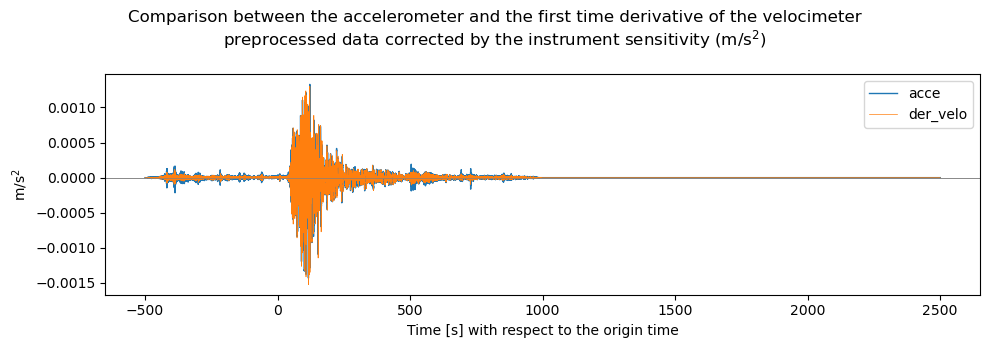

In [53]:
title = "Comparison between the accelerometer and the first time derivative of the velocimeter\npreprocessed data corrected by the instrument sensitivity (m/s$^2$)"
fig = lab.plot_time(acce, origin.time, extra_label="acce", title=title)
fig = lab.plot_time(der_velo, origin.time, linewidth=0.5, extra_label="der_velo", fig=fig)
fig.axes[0].set_ylabel("m/s$^2$");

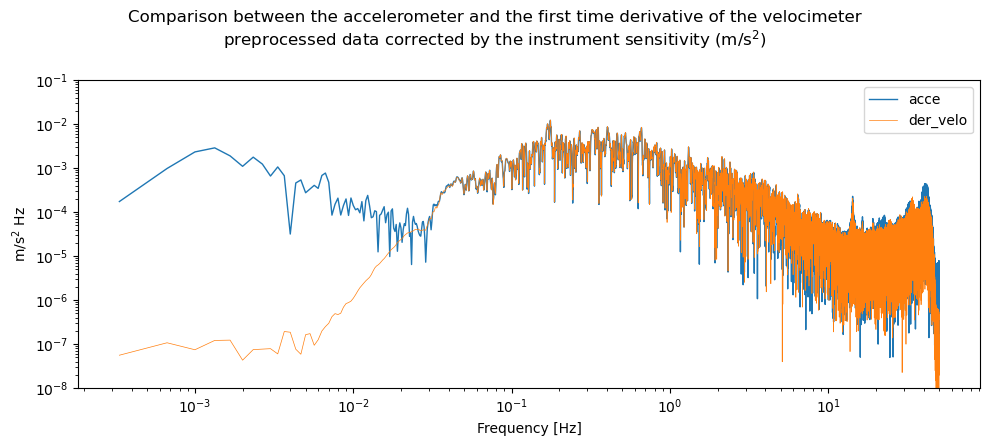

In [54]:
title = "Comparison between the accelerometer and the first time derivative of the velocimeter\npreprocessed data corrected by the instrument sensitivity (m/s$^2$)"
fig = lab.plot_fft(acce, extra_label="acce", title=title)
fig = lab.plot_fft(der_velo, linewidth=0.5, extra_label="der_velo", fig=fig)
ax = fig.axes[0]
ax.set_ylabel("m/s$^2$ Hz")
ax.set_ylim(1e-8,1e-1);

```{div} full-width
From this last comparison in the frequency domain, we can understand that, even if the response function of the accelerometer has a flat absolute spectral amplitude in the low frequency range, it does not means that the the low frequency components reflect the ground acceleration

```

------

### Ground motion

```{div} full-width

Let us now define two functions for removing exactly the response function of each channel in order to retive the ground motion
```

In [55]:
###########################################################
def get_inverse_response(trace,output="DEF"):
    
    response = trace.stats.response

    end_stage = len(response.response_stages) - 1
    
    n, d = trace.stats.npts, trace.stats.delta    
    Rs, fs = response.get_evalresp_response(d,n,output=output,end_stage=end_stage)
    Rs[0] = np.inf
    IRs = 1/Rs
    
    return fs,IRs
###########################################################


###########################################################
def remove_response(stream,output="DEF"):
    ground = stream.copy()
    for trace in ground:
        fs,IRs = get_inverse_response(trace,output=output)
        fs,Zs,n,d = get_fft_trace(trace)
        trace.data = np.fft.irfft(Zs*IRs,n) / d
    return ground
###########################################################


```{div} full-width
and apply them to the preprocessed stream to retive the ground motion 
```

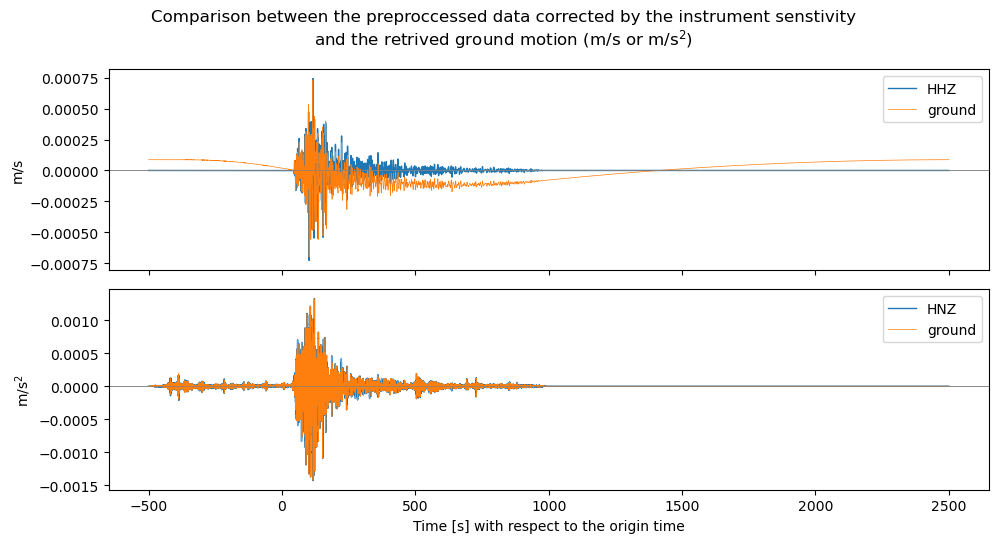

In [56]:
ground = remove_response(stream)
title = "Comparison between the preproccessed data corrected by the instrument senstivity\nand the retrived ground motion (m/s or m/s$^2$)"
fig = lab.plot_time(stream_sens, origin.time, title=title)
fig = lab.plot_time(ground,      origin.time, fig=fig, extra_label="ground", linewidth=0.5)
fig.axes[0].set_ylabel("m/s")
fig.axes[1].set_ylabel("m/s$^2$");

```{div} full-width
By the way in which we have defined them, we can also decide the desired output for which the response function has to be calculated, as for instance the velocity 
```

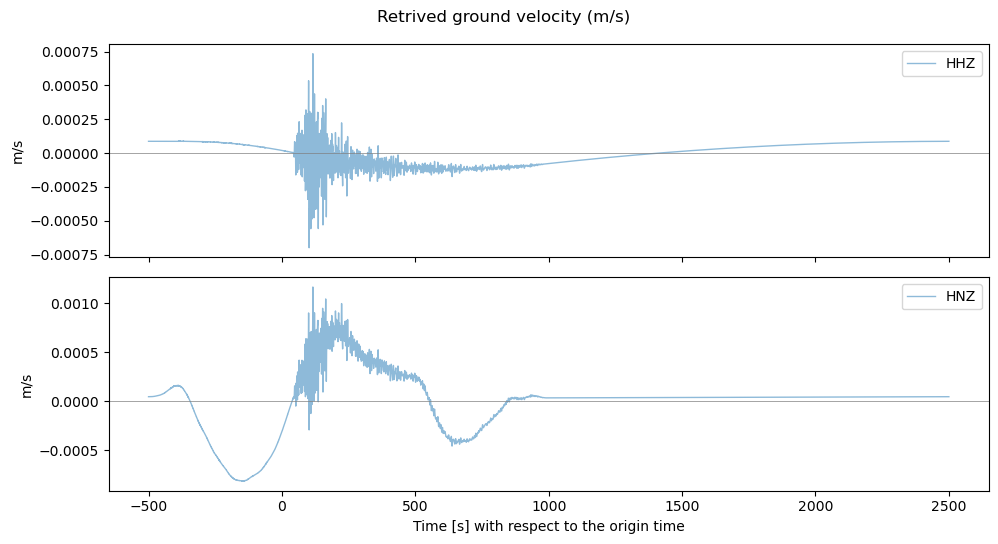

In [57]:
ground_velo = remove_response(stream,output="VEL")

title = "Retrived ground velocity (m/s)"
fig = lab.plot_time(ground_velo, origin.time, title=title, alpha=0.5)
for ax in fig.axes:
    ax.set_ylabel("m/s")

```{div} full-width
or the displacement
```

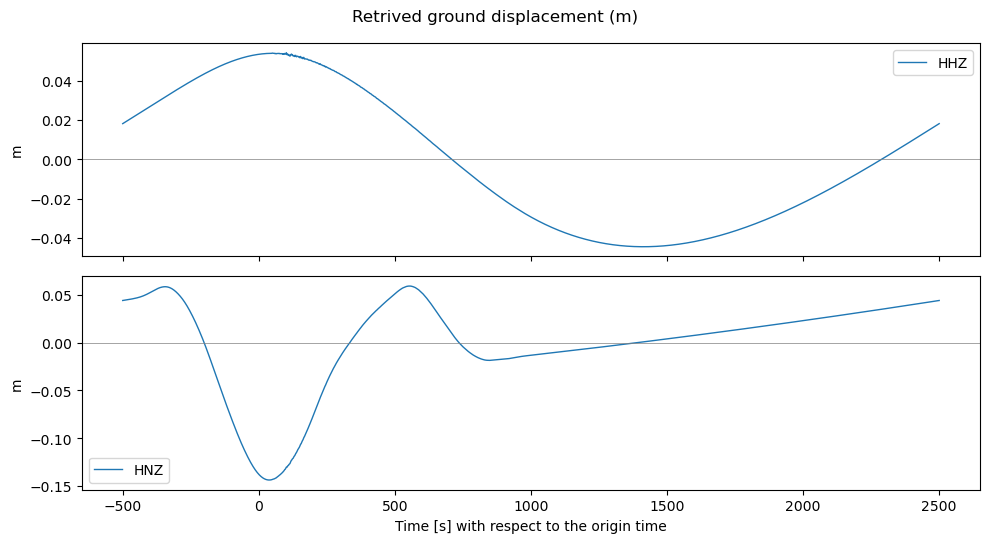

In [58]:
ground_disp = remove_response(stream,output="DISP")

title = "Retrived ground displacement (m)"
fig = lab.plot_time(ground_disp, origin.time, title=title)
for ax in fig.axes:
    ax.set_ylabel("m")

```{div} full-width
In order to understand whether the above ground displacements  make sense for an earthquake, let us consider the following plot of their spectra in the frequency domain
```

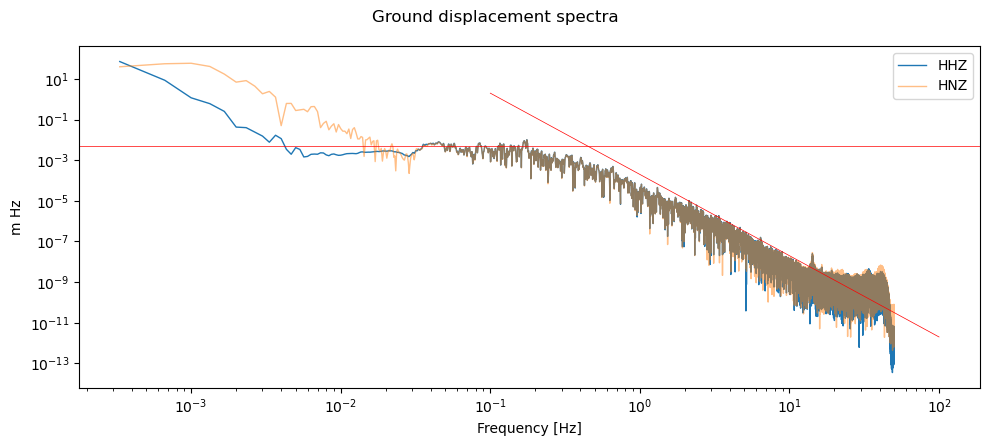

In [59]:
title = "Ground displacement spectra"
fig = lab.plot_fft(ground_disp.select(channel="HH*"),title=title)
fig = lab.plot_fft(ground_disp.select(channel="HN*"),fig=fig,alpha=0.5)

fs = 1e1**np.linspace(-1,2)
for ax in fig.axes:
    ax.set_xlabel("Frequency [Hz]")
    ax.axhline(5e-3,linewidth=0.5,color="red")
    ax.plot(fs,2e-4/fs**4,linewidth=0.5,color="red")
    ax.set_ylabel("m Hz")

```{div} full-width
Ground displacement spectra. On the basis of the $\omega^2$-model we should expect flat spectral amplitudes in the low frequency range and, indeed, this is the case from 0.006 to 0.2 Hz for the velocimeter (HHZ) and from 0.02 to 0.2 Hz for the accelerometer (HNZ). Nevertheless, at lower frequencies, the spectral amplitudes increase. Also, at high frequency, we shall expect that the spectral amplitudes decrease with increasing frequencies and that this feature should be even more pronunced once scattering and analestic attenuation is considered. This occurs up to about 15 Hz although, at higer frequency, the decreases stop.
```

## Noise

```{div} full-width
In order to understand the physical discrepancies about the spectral amplituded of the ground displacement, let us select a time window where no earthquake occurs by trimming the origial stream up to the origin time and performing the standard preprocessing and, then, retriving the ground displacement 

In [60]:
noise = original_stream.copy()
missing = noise.attach_response(inventory)
noise.trim(endtime=origin.time)
noise = preprocessing(noise)
ground_disp_noise = lab.remove_response(noise,output="DISP")

```{div} full-width
Then, we compare the spectral amplitude of the ground displacements in the noisy time window with those including the earthquake
```

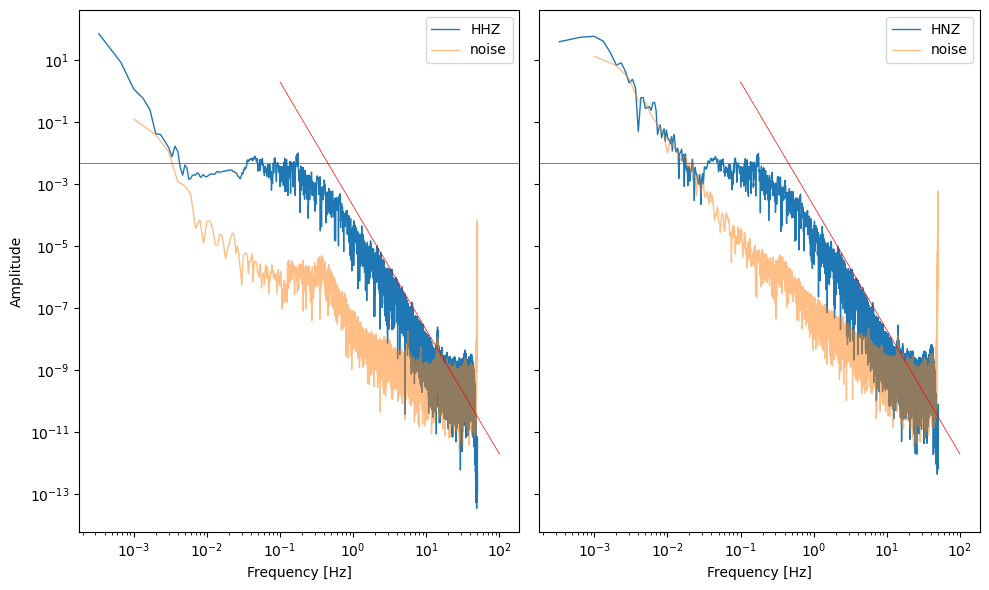

In [61]:
fig = lab.plot_fft(ground_disp)
fig = lab.plot_fft(ground_disp_noise, fig=fig, alpha=0.5, extra_label="noise")
fig.set_size_inches(10,6)

fs = 1e1**np.linspace(-1,2)
for ax in fig.axes:
    ax.set_xlabel("Frequency [Hz]")
    ax.axhline(5e-3,linewidth=0.5,color="red")
    ax.plot(fs,2e-4/fs**4,linewidth=0.5,color="red")

### Filtering

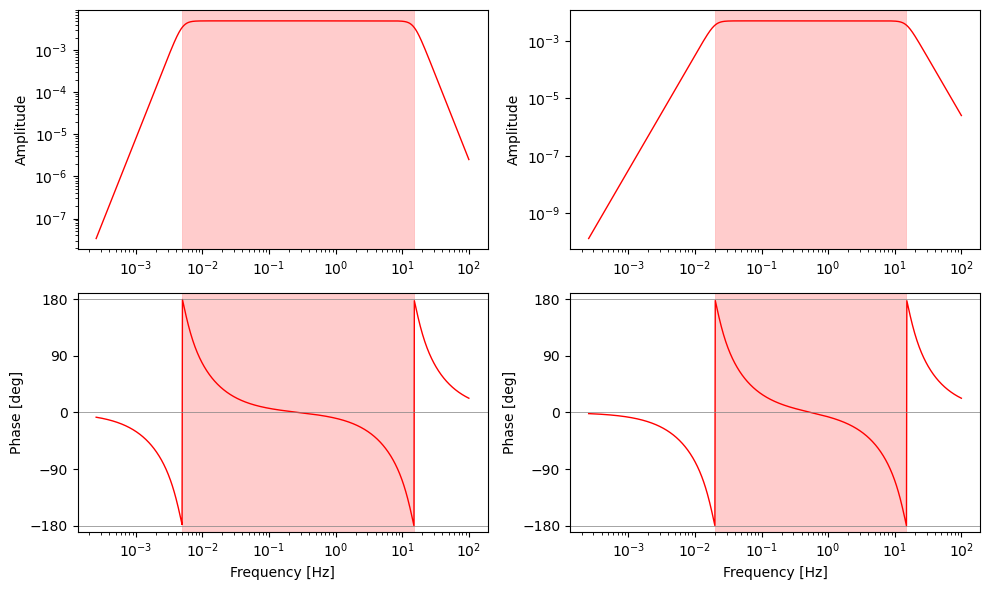

In [62]:
from scipy import signal

bands = np.array([[5e-3,15],[2e-2,15]])

BA_filters = []
for band in bands:
    BA_filter = signal.butter(4, 2*np.pi*band, "bandpass", analog=True)
    BA_filters.append(BA_filter)

fs = 1e1**np.linspace(-3.6,2,1000)
ws = 2*np.pi*fs

fig,axes = plt.subplots(2, 2, figsize=(10,6), tight_layout=True)

for axe,band,BA_filter in zip(axes.T,bands,BA_filters):
    ws, Hs = signal.freqs(*BA_filter, ws)
    lab.plot_spectrum(fs, 5e-3*Hs, axe, band=band, color="red")
    for ax in axe:
        ax.set_xscale("log")

In [63]:
def filtering(stream,BA_filters):
    fil_stream = stream.copy()
    for trace,BA_filter in zip(fil_stream,BA_filters):
        fs,Zs,n,d = get_fft_trace(trace)
        ws = 2*np.pi*fs
        ws, Hs = signal.freqs(*BA_filter, ws)
        trace.data = np.fft.irfft(Zs*Hs,n) / d
    return fil_stream 

In [64]:
filtered_stream = lab.filtering(stream,BA_filters)
filtered_noise  = lab.filtering(noise,BA_filters)

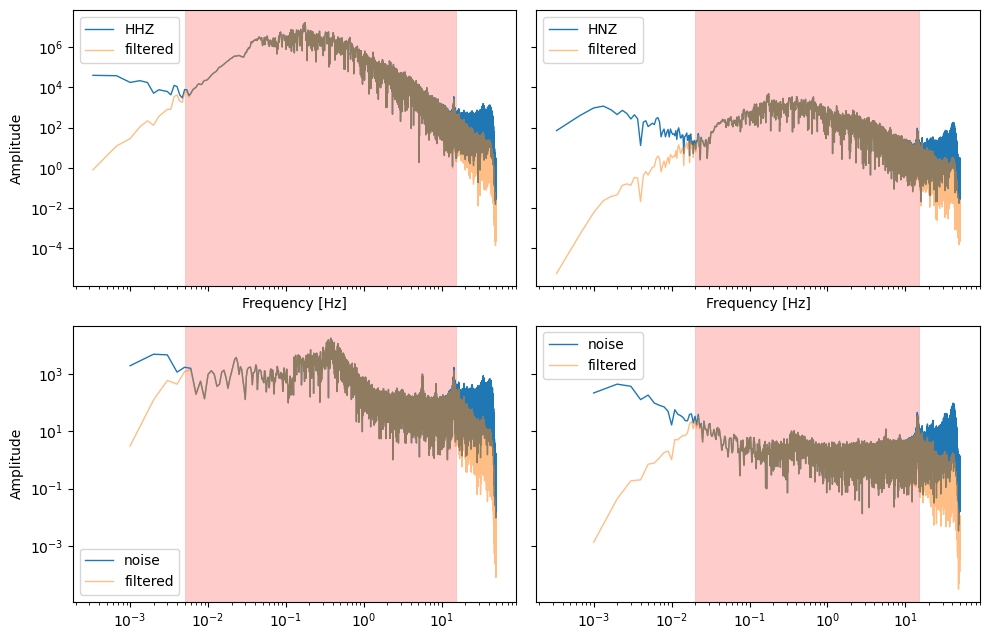

In [65]:
fig = lab.plot_fft(stream, nrow=2, bands=bands)
fig = lab.plot_fft(noise,  row=1,  bands=bands, fig=fig, extra_label="noise")
fig = lab.plot_fft(filtered_stream, fig=fig, row=0, extra_label="filtered", alpha=0.5)
fig = lab.plot_fft(filtered_noise,  fig=fig, row=1, extra_label="filtered", alpha=0.5)

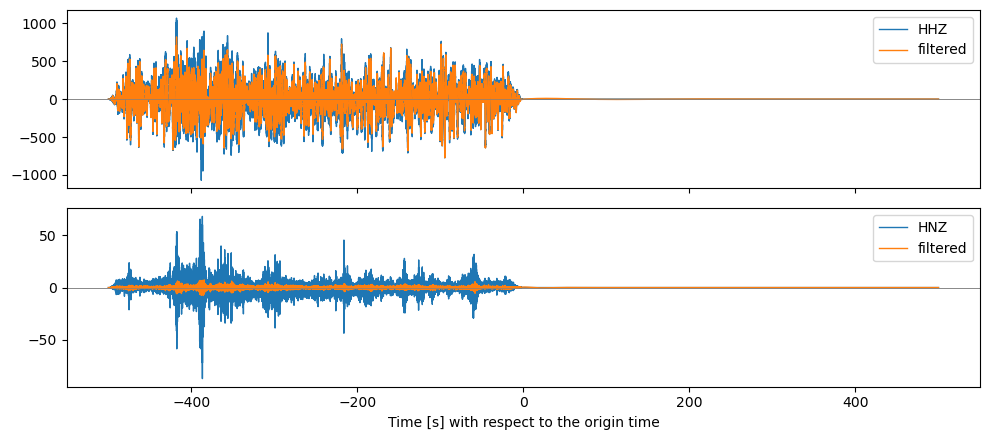

In [66]:
fig = lab.plot_time(noise, origin.time)
fig = lab.plot_time(filtered_noise, origin.time, fig=fig,  extra_label="filtered")

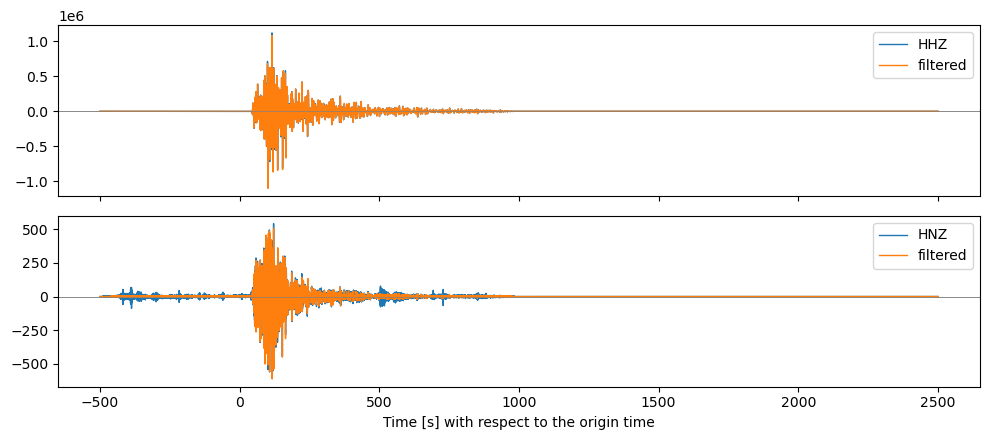

In [67]:
fig = lab.plot_time(stream, origin.time)
fig = lab.plot_time(filtered_stream, origin.time, fig=fig, extra_label="filtered")

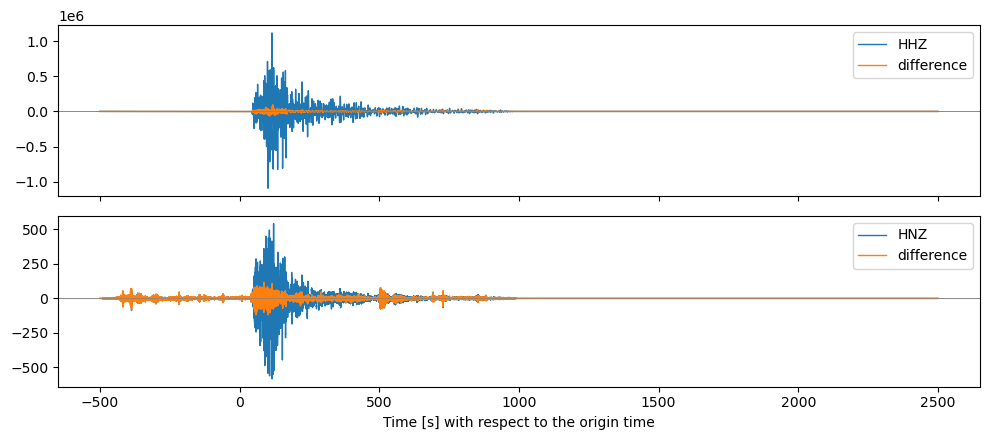

In [68]:
diff = stream.copy()
for trace,filtered_trace in zip(diff,filtered_stream):
    trace.data = trace.data-filtered_trace.data
fig = lab.plot_time(stream, origin.time)
fig = lab.plot_time(diff,       origin.time, fig=fig, extra_label="difference")

### Zero phase filtering

In [69]:
def filtering_zerophase(stream,BA_filter):
    new = stream.copy()
    for trace in new:
        fs,Zs,n,d = get_fft_trace(trace)
        ws = 2*np.pi*fs
        ws, Hs = signal.freqs(*BA_filter, ws)
        zs = np.fft.irfft(Zs*Hs,n)
        zs = np.flip(zs)
        Zs = np.fft.rfft(zs)
        zs = np.fft.irfft(Zs*Hs,n)
        zs = np.flip(zs)
        trace.data = zs
    return new

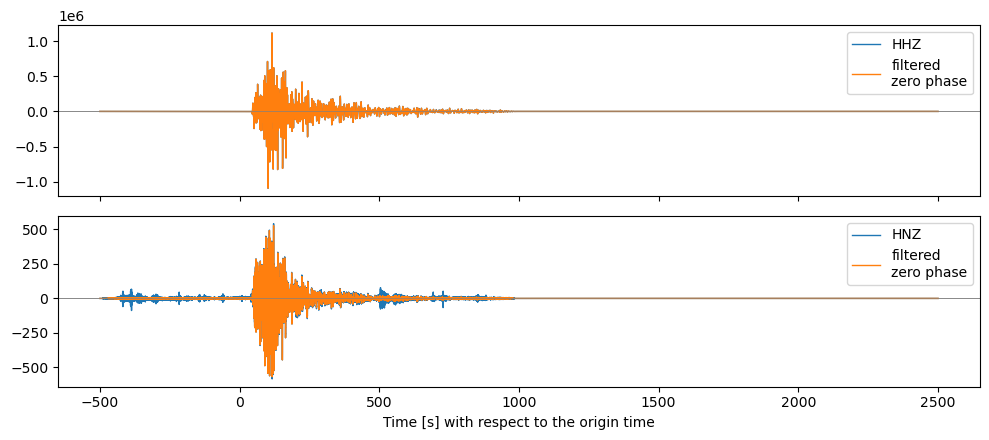

In [70]:
filtered_zerophase_stream = lab.filtering_zerophase(stream,BA_filters)

fig = lab.plot_time(stream, origin.time)
fig = lab.plot_time(filtered_zerophase_stream, origin.time, fig=fig, extra_label="filtered\nzero phase")

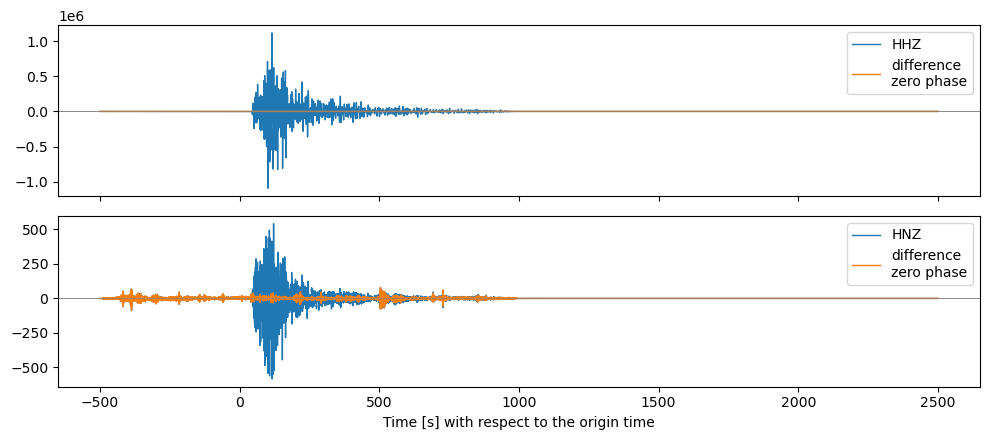

In [71]:
diff_zerophase_stream = stream.copy()
for trace,filtered_trace in zip(diff_zerophase_stream,filtered_zerophase_stream):
    trace.data = trace.data-filtered_trace.data
fig = lab.plot_time(stream, origin.time)
fig = lab.plot_time(diff_zerophase_stream, origin.time, fig=fig, label_id=False, extra_label="difference\nzero phase")

## Ground motion and picking

```{div} full-width
Let us now remove the response function from the zerophase filtered stream and plot the result comparing the ground displacement, velocity and acceleration obtained from the velocimeter and the accelerometer
```

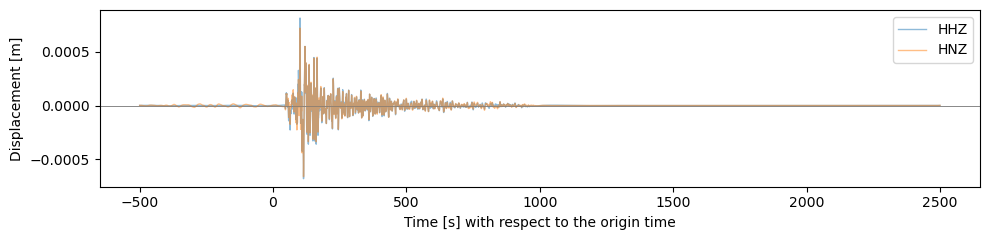

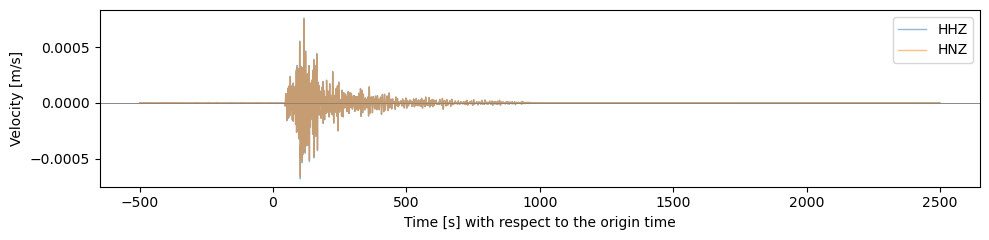

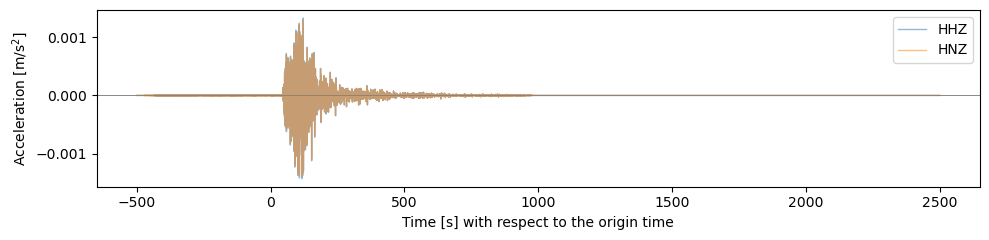

In [72]:
for output,label in zip( ["DISP","VEL","ACC"], ["Displacement [m]", "Velocity [m/s]", "Acceleration [m/s$^2$]"] ):
    ground = remove_response(filtered_zerophase_stream,output=output)

    fig = lab.plot_time(ground.select(channel="HH*"), origin.time, alpha=0.5)
    fig = lab.plot_time(ground.select(channel="HN*"), origin.time, fig=fig, alpha=0.5)
    for ax in fig.axes:
        ax.set_ylabel(label)

```{div} full-width

As we can see, the ground motions from the two kind of instrument look simila to each other, but for some minor differences mainly conerning the ground displacement. 
```

<p style="page-break-after:always;"></p>